In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# add (../..) to the path so that python packages are findable
import sys
sys.path.append('../..')

In [5]:
from src.functionvectors.utils.conceptors import combine_conceptors, combine_conceptors_and, compute_conceptor

In [6]:
Xs = [torch.rand((1600, 5000)) for _ in range(4)]
Cs = [compute_conceptor(X, 0.1) for X in Xs]

In [8]:
torch.sum(torch.abs(
    combine_conceptors(Cs[0], Cs[1]) - combine_conceptors_and(Cs[0], Cs[1])
))

tensor(4759.8989)

## compare rescaling vs. recomputing

In [2]:
cc = torch.load('src/functionvectors/conceptors_cache.pt')

/tmp/ipykernel_380921/1273641321.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cc = torch.load('src/functionvectors/conceptors_cache.pt')


In [5]:
def scale_conceptor(C, aperture_scaling_factor):
    return C @ np.linalg.inv(C + (aperture_scaling_factor**-2) * (np.eye(C.shape[0]) - C))

def rescale_conceptor(C, prev_alpha, new_alpha):
    return scale_conceptor(C, new_alpha / prev_alpha)

In [7]:
mismatches = []
for k in cc.keys():
    print(f"Experiment {k}")
    for (n1, alpha1) in cc[k].keys():
        for (n2, alpha2) in cc[k].keys():
            if n1 == n2 and alpha1 != alpha2:
                print(f" {n1} {alpha1} {alpha2}")
                c1 = cc[k][(n1, alpha1)].numpy()
                c2 = cc[k][(n2, alpha2)].numpy()
                c2 = rescale_conceptor(c2, alpha2, alpha1)
                diff = np.linalg.norm(c1 - c2)
                print(f"  mismatch: {diff:.5f}")
                c1 = cc[k][(n1, alpha1)].numpy()
                c2 = cc[k][(n2, alpha2)].numpy()
                c1 = rescale_conceptor(c1, alpha1, alpha2)
                diff2 = np.linalg.norm(c1 - c2)
                print(f"  mismatch: {diff2:.5f}")
                mismatches.append((diff, diff2))

Experiment 0
 28 0.001 0.0125


  mismatch: 0.00008
  mismatch: 0.00002
 28 0.001 0.05
  mismatch: 0.00127
  mismatch: 0.00033
 28 0.001 0.1
  mismatch: 0.00531
  mismatch: 0.00131
 28 0.0125 0.001
  mismatch: 0.00002
  mismatch: 0.00008
 28 0.0125 0.05
  mismatch: 0.00003
  mismatch: 0.00001
 28 0.0125 0.1
  mismatch: 0.00013
  mismatch: 0.00005
 28 0.05 0.001
  mismatch: 0.00033
  mismatch: 0.00127
 28 0.05 0.0125
  mismatch: 0.00001
  mismatch: 0.00003
 28 0.05 0.1
  mismatch: 0.00002
  mismatch: 0.00001
 28 0.1 0.001
  mismatch: 0.00131
  mismatch: 0.00531
 28 0.1 0.0125
  mismatch: 0.00005
  mismatch: 0.00013
 28 0.1 0.05
  mismatch: 0.00001
  mismatch: 0.00002
 32 0.001 0.0125
  mismatch: 0.00003
  mismatch: 0.00002
 32 0.001 0.05
  mismatch: 0.00052
  mismatch: 0.00029
 32 0.001 0.1
  mismatch: 0.00211
  mismatch: 0.00116
 32 0.0125 0.001
  mismatch: 0.00002
  mismatch: 0.00003
 32 0.0125 0.05
  mismatch: 0.00001
  mismatch: 0.00002
 32 0.0125 0.1
  mismatch: 0.00005
  mismatch: 0.00006
 32 0.05 0.001
  mismat

Mean: 0.0005144985637345228, Std: 0.001228248330363909, Min: 5.580534573945147e-07, Max: 0.0078114321223637945


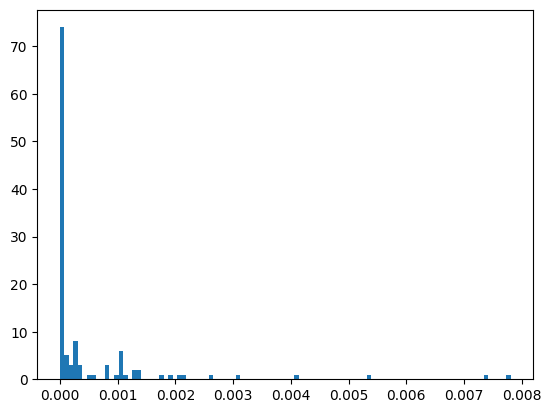

In [12]:
mm = np.array(mismatches)
print(f"Mean: {mm.mean()}, Std: {mm.std()}, Min: {mm.min()}, Max: {mm.max()}")
plt.hist(mm[:, 0], bins=100);

Norms of conceptor differences (different tasks)
Mean: 5.0649, Std: 2.5756, Min: 0.1142, Max: 8.7521


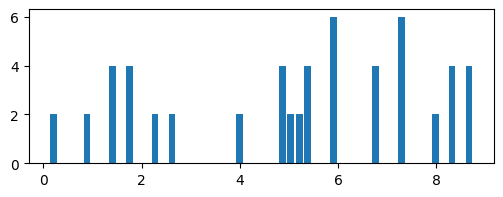

In [13]:
key = 0
dif_norms = []
for i1, k1 in enumerate(cc[key].keys()):
    for i2, k2 in enumerate(cc[key].keys()):
        c1 = cc[key][k1]
        c2 = cc[key][k2]
        # print(i1, i2, np.linalg.norm(c1-c2))
        if i1 != i2:
            dif_norms.append(np.linalg.norm(c1-c2))
dn = np.array(dif_norms)
print("Norms of conceptor differences (different tasks)")
print(f"Mean: {dn.mean():.4f}, Std: {dn.std():.4f}, Min: {dn.min():.4f}, Max: {dn.max():.4f}")
_, ax = plt.subplots(figsize=(6, 2))
ax.hist(dn, bins=50, rwidth=0.8);

Norms of conceptor differences (same task, different random experiment)
Mean: 0.0302, Std: 0.0014, Min: 0.0283, Max: 0.0327


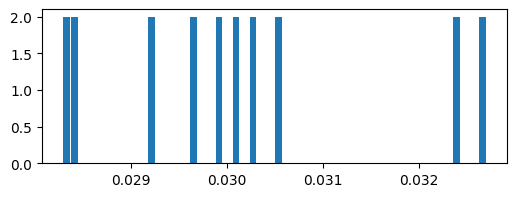

In [14]:
dif_norms = []
subkey = list(cc[0].keys())[0]
for k1 in cc.keys():
    for k2 in cc.keys():
        c1 = cc[k1][subkey]
        c2 = cc[k2][subkey]
        # print(k1, k2, np.linalg.norm(c1-c2))
        if k1 != k2:
            dif_norms.append(np.linalg.norm(c1-c2))
dn = np.array(dif_norms)
print("Norms of conceptor differences (same task, different random experiment)")
print(f"Mean: {dn.mean():.4f}, Std: {dn.std():.4f}, Min: {dn.min():.4f}, Max: {dn.max():.4f}")
_, ax = plt.subplots(figsize=(6, 2))
ax.hist(dn, bins=50, rwidth=0.8);